# Qubit tomography

This notebook shows how we can do 1-2 qubit tomography with sampling results.

In [5]:
# imports
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import scipy
import numpy as np
from utils import *
from copy import deepcopy
from qiskit_experiments.library import StateTomography
from qiskit_aer.primitives import SamplerV2
from qiskit.quantum_info import Statevector, DensityMatrix

## 2 qubit tomography

In [10]:
state_p = np.outer(np.array([1,1]),np.array([1,1]))/2

In [4]:
bell = QuantumCircuit(2,2)
bell.h(0)
bell.x(1)

# initialization of the sampler
sampler = SamplerV2()
# collect 128 shots from the Bell circuit
bell_meas_all = deepcopy(bell)
bell_meas_all.measure_all()
job = sampler.run([bell_meas_all], shots=1000)
job_result = job.result()
print(f"counts for Bell circuit : {job_result[0].data.meas.get_counts()}")

counts for Bell circuit : {'10': 501, '11': 499}


Without running simulations, we can obtain statevector generated by the circuit using `statevector_simulator`. We will use this result to calculate the fidelity of our DME circuit.

In [11]:
state_vec = Statevector.from_instruction(bell)
dm_expect = DensityMatrix(state_vec).data
print(dm_expect)

[[0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.5+0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0.5+0.j 0.5+0.j]]


To obtain the density matrix from simulation, we need to first choose the backend. Here for convenience, we are using fake backends (models hard coded based on real QPU snapshots).

In [6]:
from qiskit_ibm_runtime.fake_provider import *

In [7]:
def select_qubit_by_t1(t1_list, t1, per_diff):
    '''Select the qubits whose T1 within per_diff(%) from prescribed t1'''
    lower_bound = t1 * (1-per_diff)
    upper_bound = t1 * (1+per_diff)
    result_dict = {index: t1 for index, t1 in enumerate(t1_list) if lower_bound <= t1 <= upper_bound}
    return result_dict

[412.7753747617601, 375.07489010659486, 265.64214727319415, 400.4961700515289, 340.856076758169, 250.8130291526954, 267.67265625341906, 330.5731300910833, 231.30774072593567, 333.52873408602113, 136.6863325205695, 351.1563701899266, 331.3298178417412, 253.22142958745104, 267.0923265803207, 397.4361949326733, 7.717159571191255, 269.27695686008263, 347.864070099189, 425.3035879121343, 421.23933418602957, 392.37014792539696, 253.15691483895327, 436.36938283642286, 316.76227488590166, 226.90629133148744, 260.1475420199427, 337.62618543292245, 194.4081356162863, 353.59895532161244, 258.9769837289377, 330.321406207079, 356.0144772815951, 38.151618158831965, 288.5432892725094, 264.1795067406931, 300.78514134890037, 169.47594200977812, 325.5788039664015, 257.50567374892813, 227.8620566543772, 191.7135633613438, 183.9303999566668, 265.9728281803564, 322.9793547058911, 364.4226896800889, 312.91425133275817, 401.673282243488, 346.5263676161572, 211.05795107561104, 250.355822881582, 74.56596058159

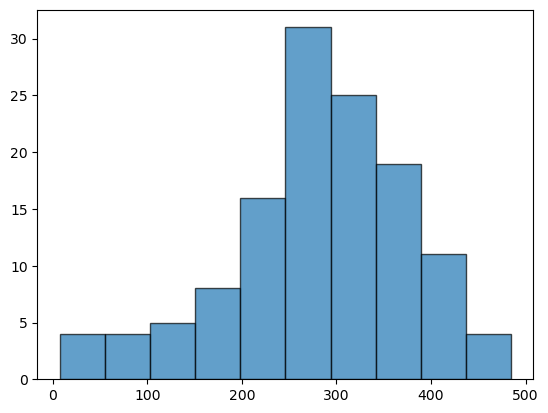

In [8]:
# Measure T1
# Load the Fake backend
fakebackend = FakeOsaka()


# Get the backend properties
properties = fakebackend.properties()

# Extract T1 times for each qubit
t1_times = [qubit[0].value for qubit in properties.qubits if qubit[0].name == 'T1']
print(t1_times)
plt.hist(t1_times, bins=10, edgecolor='black', alpha=0.7)
t1_100_dict = select_qubit_by_t1(t1_times, 50, 0.2)
# Print T1 times
for index, t1 in t1_100_dict.items():
    print(f"Qubit {index}: T1 = {t1:.2e} micro seconds")

In [12]:
tomo_exp = StateTomography(bell)
tomo_backend = AerSimulator.from_backend(fakebackend)
tomo_data = tomo_exp.run(backend=tomo_backend, shots = 3000)
tomo_data.block_for_results()
tomo_results = tomo_data.analysis_results("state")
dm_sim = tomo_results.value

# Display the density matrix
print("Reconstructed Density Matrix:")
print(dm_sim)

Reconstructed Density Matrix:
DensityMatrix([[ 0.01022827+0.00000000e+00j,  0.00526523+1.10037182e-03j,
                -0.00278997+9.79548819e-03j,  0.00407396-2.86143002e-03j],
               [ 0.00526523-1.10037182e-03j,  0.00336289-1.18827244e-19j,
                 0.00465775+1.11680733e-04j,  0.00360635-8.48313800e-03j],
               [-0.00278997-9.79548819e-03j,  0.00465775-1.11680733e-04j,
                 0.48848302-9.66079209e-18j,  0.4687    -1.33594739e-03j],
               [ 0.00407396+2.86143002e-03j,  0.00360635+8.48313800e-03j,
                 0.4687    +1.33594739e-03j,  0.49792582-8.22397043e-18j]],
              dims=(2, 2))


In [13]:
print(fidelity(dm_sim, dm_expect))

0.961904423629786


We see that here the circuit generating bell state with noise results in about 90% fidelity.

## SWAP operator fidelity
2 qubit circuit. Initial state in $|0\rang\otimes|1\rang$

In [6]:
from qiskit_ibm_runtime.fake_provider import *
fakebackend = FakeOsaka()
tomo_backend = AerSimulator.from_backend(fakebackend)

In [7]:
# reference state
state_0 = np.outer(np.array([1,0]),np.array([1,0]))
state_1 = np.outer(np.array([0,1]),np.array([0,1]))
state_p = np.outer(np.array([1,1]),np.array([1,1]))/2
swap_matrix = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])
def expect_state(d1, d2, t):
    swap_interaction = scipy.linalg.expm(-1j*t*swap_matrix)
    swap_interaction_dag = scipy.linalg.expm(1j*t*swap_matrix)
    return swap_interaction @ np.kron(d1, d2) @ swap_interaction_dag

In [11]:
t_range = np.linspace(0, np.pi, 20)
nshots = 1000
fidelity_ls = []
for i, t in enumerate(t_range):
    qc = QuantumCircuit(2)
    qc.x(1)
    add_partial_swap(qc, 0, 1, t=t)
    dm_sim = qiskit_tomography(qc, tomo_backend, 1000)
    state_vec = Statevector.from_instruction(qc)
    dm_expect = DensityMatrix(state_vec).data
    fidelity_ls.append(fidelity(dm_sim, dm_expect))

Text(0, 0.5, 'Fidelity')

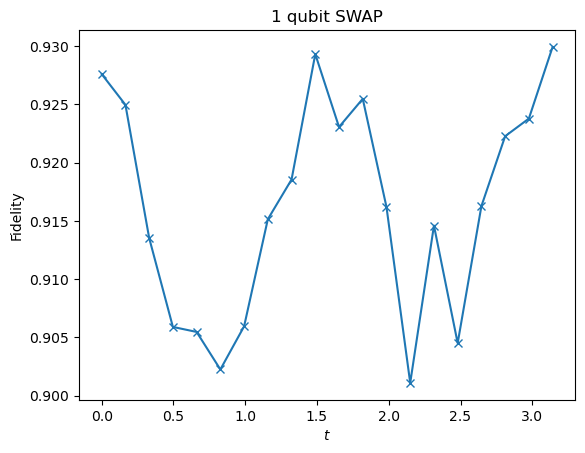

In [15]:
plt.plot(t_range, fidelity_ls, marker='x')
plt.title('1 qubit SWAP')
plt.xlabel(r'$t$')
plt.ylabel('Fidelity')